# polly

Example notebook

Jake Pember
Updated 2024-09-06

This notebook demonstrates the use of the KPF etalon analysis code polly

---
### Dependencies

```
python >= 3.7
numpy
astropy
scipy
matplotlib
tqdm
```

---
### Imports

In [1]:
from __future__ import annotations
from pathlib import Path
from glob import glob

from astropy.io import fits
from matplotlib import pyplot as plt

try:
    from polly.etalonanalysis import Spectrum
    from polly.plotStyle import plotStyle
except ImportError:
    from etalonanalysis import Spectrum
    from plotStyle import plotStyle
plt.style.use(plotStyle)

`polly` has a class structure of `Spectrum` <-> `Order` <-> `Peak` objects. All normal interfacing can be done at the `Spectrum` level, where functions initiate calls at lower levels, or access data from lower levels to be returned by the `Spectrum`.

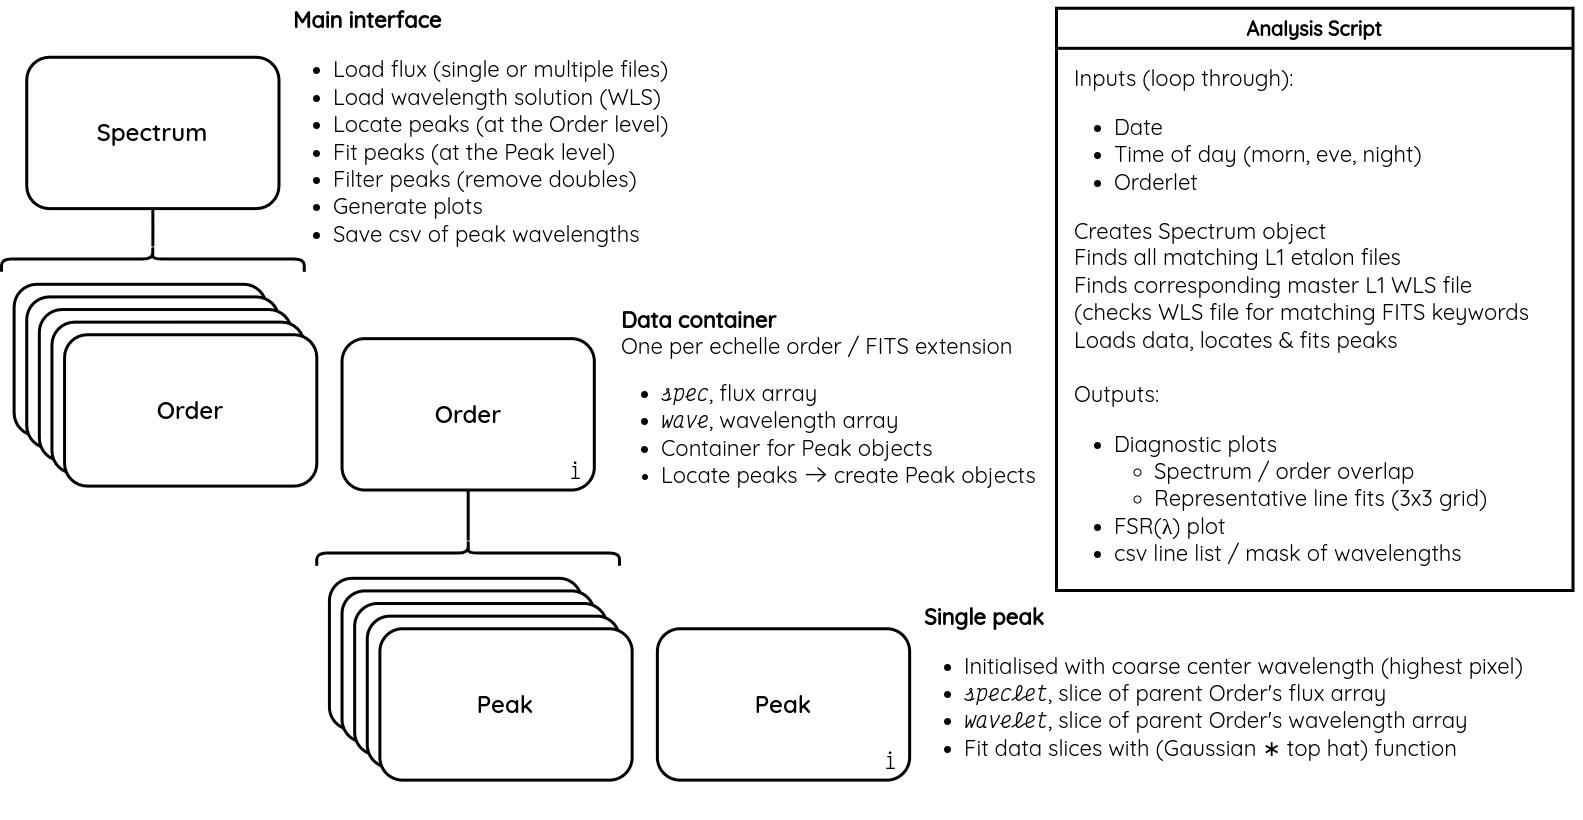

Set up all the master variables. These are nominally passed in within a `.cfg` file

In [2]:
OUTDIR: str = "/scr/jpember/temp"
# Make OUTDIR if it does not exist yet
Path(f"{OUTDIR}").mkdir(parents=True, exist_ok=True)

ORDERLETS : list[str] = [
    # "SCI1",
    "SCI2",
    # "SCI3",
    # "CAL",
    # "SKY",
    ]

DATES = [f"202405{x:02}" for x in range(1, 2)]
TIMESOFDAY = [
    "morn",
    "eve",
    # "night",
    ]

---

### Batch processing example

This is adapted from the `run_analysis_batch.py` script

In [3]:
def find_L1_etalon_files(date: str, timeofday: str) -> dict[str, list[str]]:
    """
    Look at all L1 files for the given date, and find the etalon files
    
    Better done as a database query?
    """
    
    all_files: list[str] = glob(f"/data/kpf/L1/{date}/*.fits")
    
    selected_files: list[str] = []
    
    for f in all_files:
        object = fits.getval(f, "OBJECT")
        if "etalon" in object.lower():
            t = object.split("-")[-1]
            if t == timeofday:
                selected_files.append(f)
                
    return selected_files

[20240501  morn]    Loading SCI2 flux values from a list of 9 files... DONE
[20240501  morn]    Using WLS file: kpf_20240501_master_WLS_autocal-lfc-all-morn_L1.fits
[20240501  morn]    Locating SCI2 peaks... DONE
[20240501  morn]    Fitting SCI2 peaks with conv_gauss_tophat function...


[20240501  morn]    Orders: 100%|████████████████████████████████| 67/67 [09:02<00:00,  8.09s/order]


[20240501  morn]    Filtering SCI2 peaks to remove identical peaks appearing in adjacent orders... DONE
[20240501  morn]    Saving SCI2 peaks to /scr/jpember/temp/20240501_morn_SCI2_etalon_wavelengths.csv... DONE
[20240501  morn]    Plotting SCI2 spectrum... DONE
[20240501  morn]    Plotting SCI2 Etalon FSR... DONE
[20240501  morn]    Plotting fits of SCI2 etalon peaks... DONE
[20240501   eve]    Loading SCI2 flux values from a list of 6 files... DONE
[20240501   eve]    Using WLS file: kpf_20240501_master_WLS_autocal-lfc-all-eve_L1.fits
[20240501   eve]    Locating SCI2 peaks... DONE
[20240501   eve]    Fitting SCI2 peaks with conv_gauss_tophat function...


[20240501   eve]    Orders: 100%|████████████████████████████████| 67/67 [09:26<00:00,  8.46s/order]


[20240501   eve]    Filtering SCI2 peaks to remove identical peaks appearing in adjacent orders... DONE
[20240501   eve]    Saving SCI2 peaks to /scr/jpember/temp/20240501_eve_SCI2_etalon_wavelengths.csv... DONE
[20240501   eve]    Plotting SCI2 spectrum... DONE
[20240501   eve]    Plotting SCI2 Etalon FSR... DONE
[20240501   eve]    Plotting fits of SCI2 etalon peaks... DONE


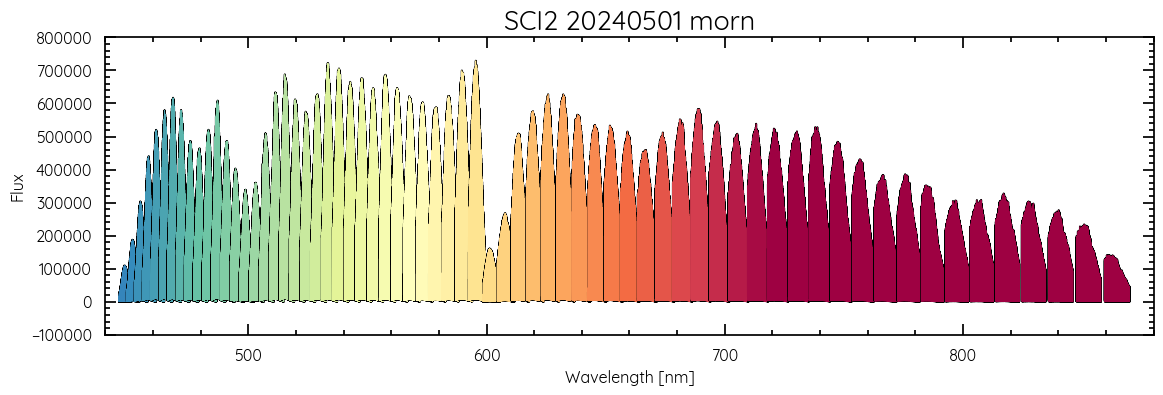

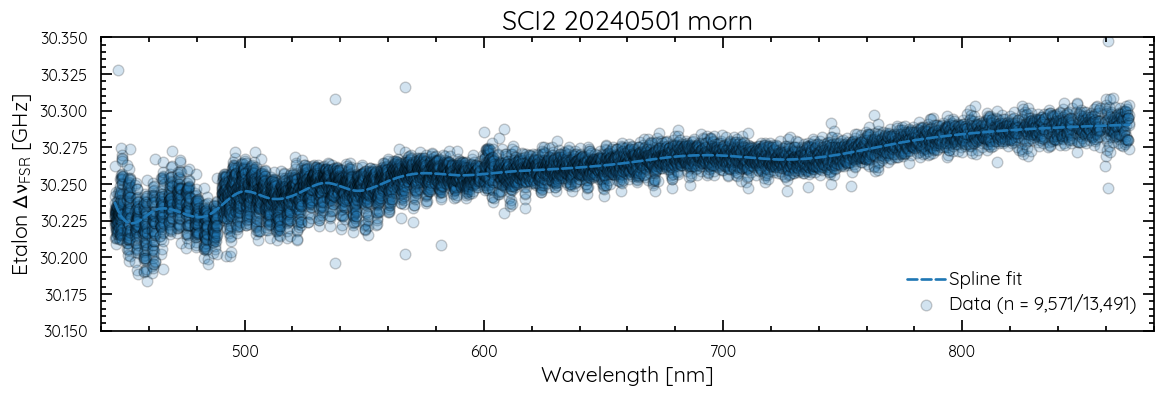

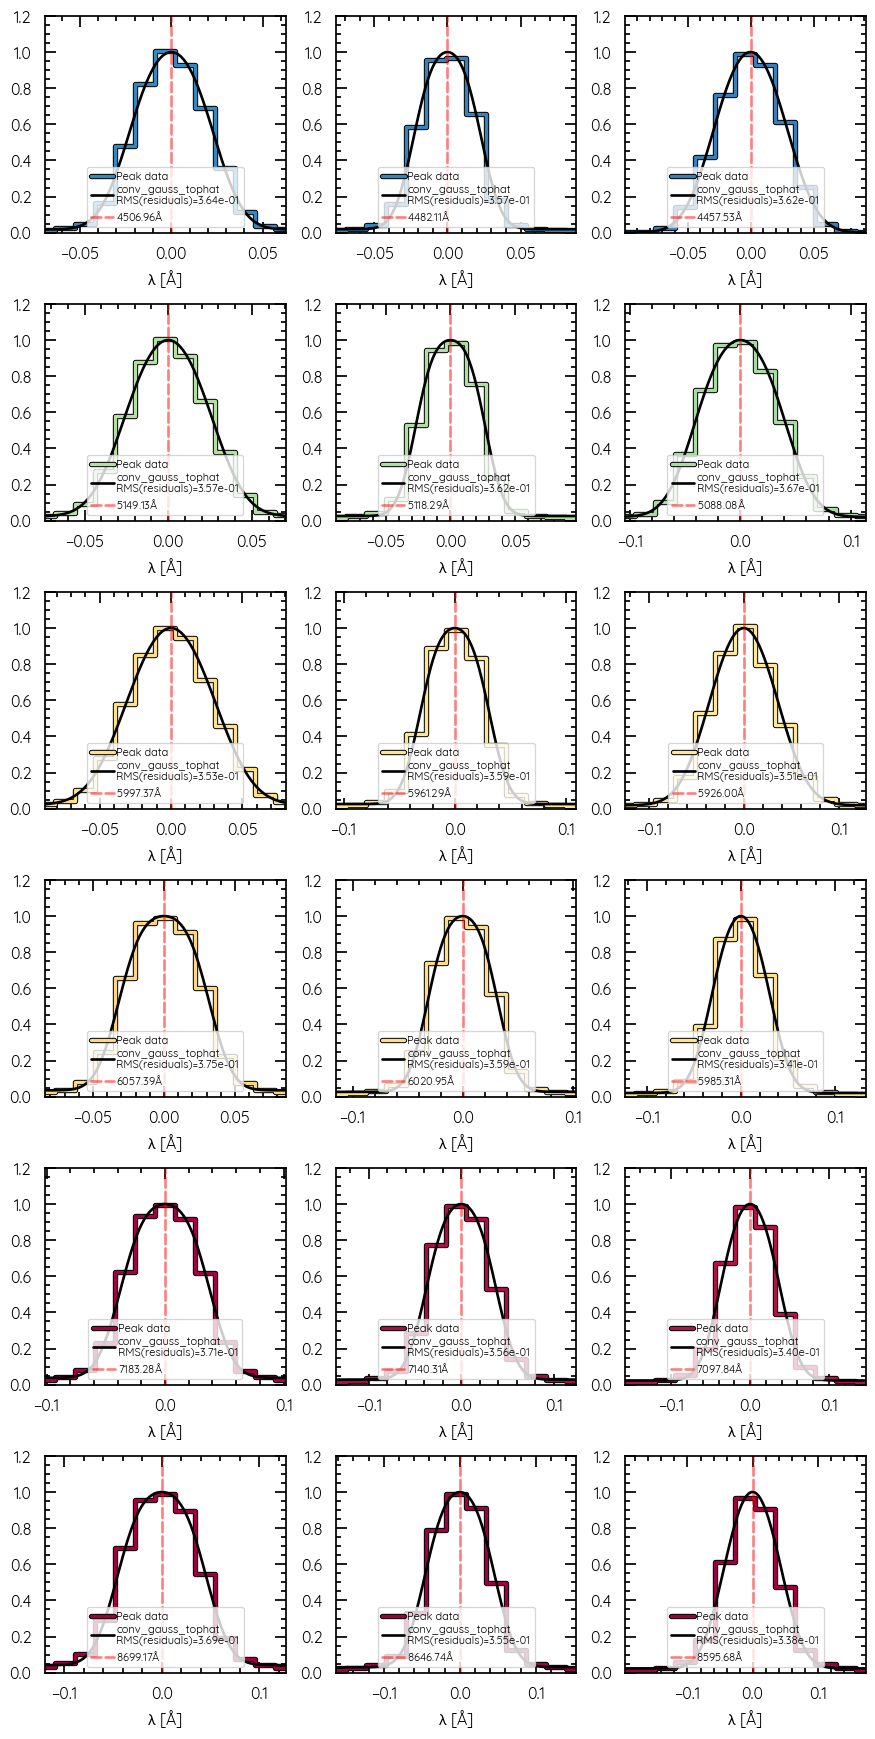

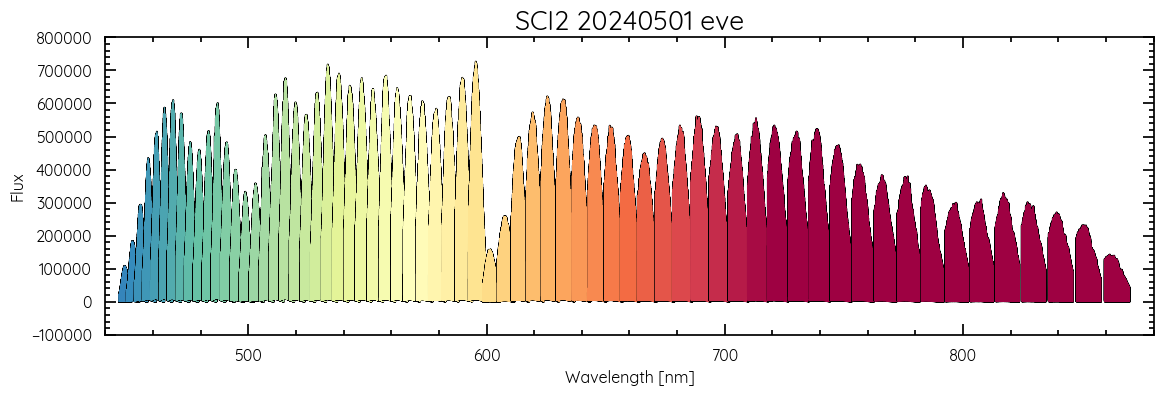

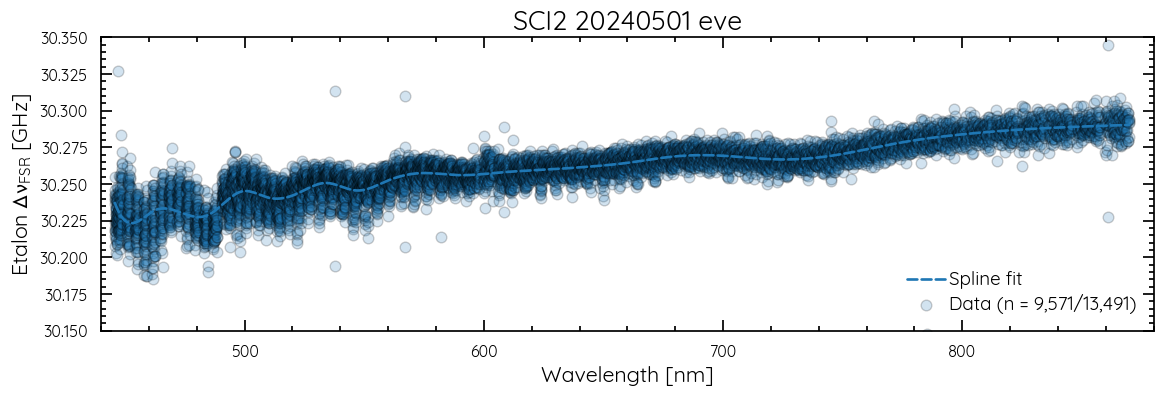

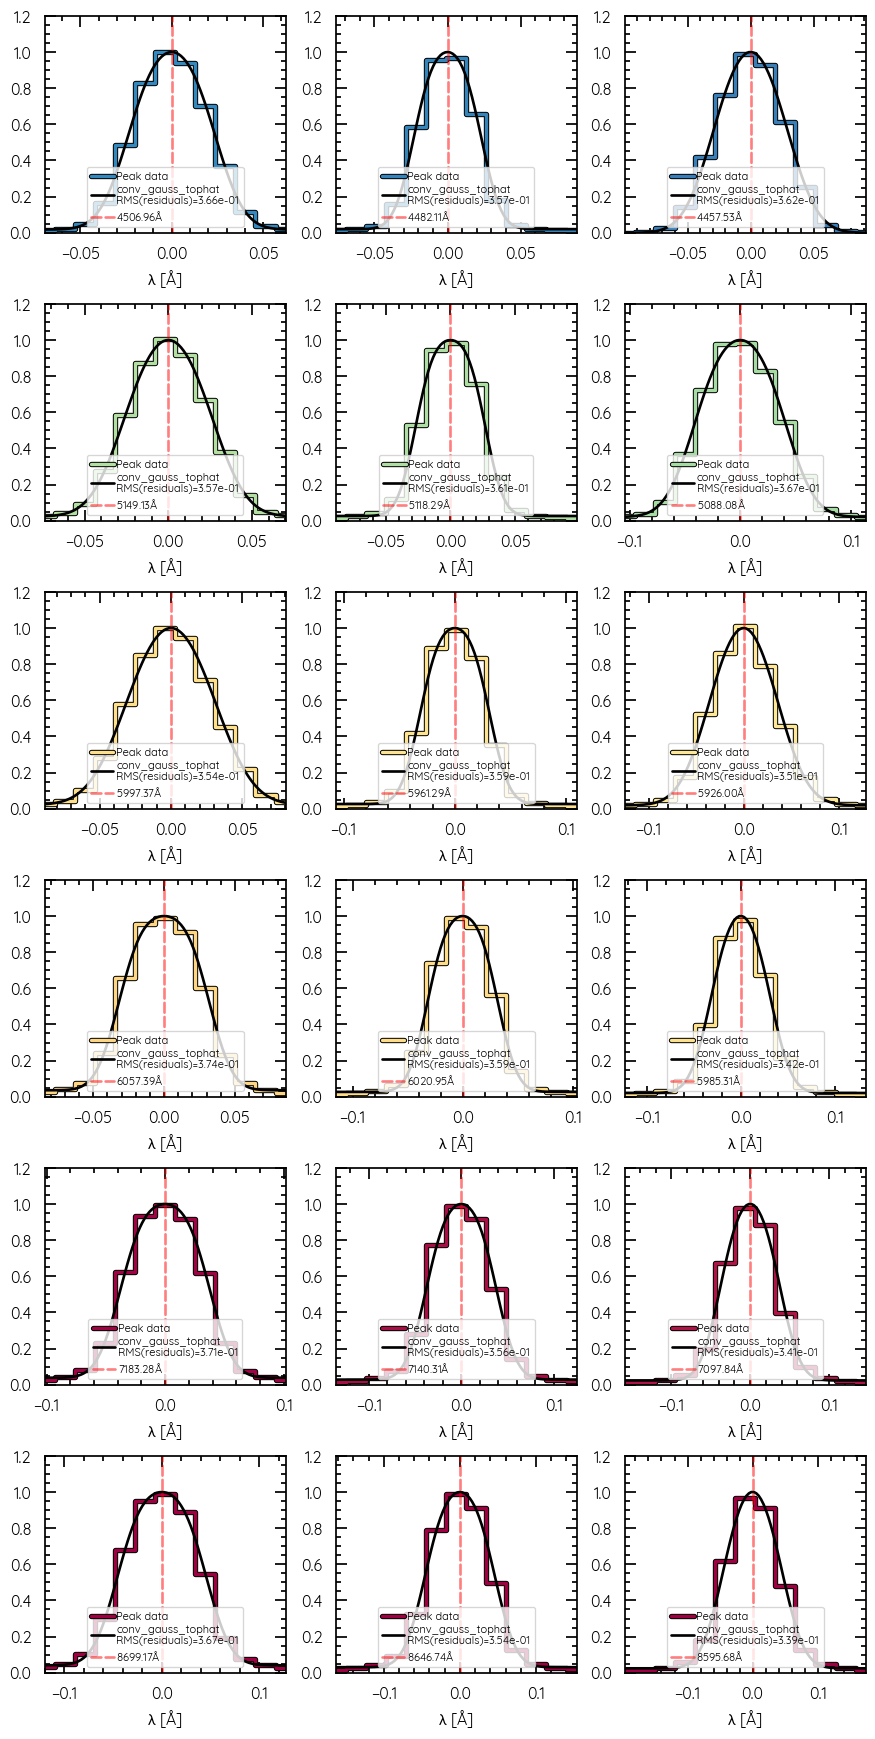

In [9]:
for date in DATES:

    for timeofday in TIMESOFDAY:

        pp = f"{f'[{date} {timeofday:>5}]':<20}" # Print/logging line prefix

        files = find_L1_etalon_files(date=date, timeofday=timeofday)
        if not files:
            print("No files found for {date} {timeofday}")
            continue

        s = Spectrum(
            spec_file = files,
            wls_file = None, # It will try to find the corresponding WLS file
            orderlets_to_load = ORDERLETS,
            pp = pp,
            )  
        s.locate_peaks(fractional_height=0.01, window_to_save=12)
        s.fit_peaks(type="conv_gauss_tophat")
        s.filter_peaks(window=0.1)
        
        for ol in s.orderlets:
            s.save_peak_locations(filename = f"{OUTDIR}/{date}_{timeofday}_{ol}_etalon_wavelengths.csv", orderlet = ol)

            s.plot_spectrum(orderlet=ol, plot_peaks=False)
            # plt.savefig(f"{OUTDIR}/spectrum_plots/"+\
            #     f"{date}_{timeofday}_{ol}_spectrum.png")
            # plt.close()

            s.plot_FSR(orderlet=ol)
            # plt.savefig(f"{OUTDIR}/FSR_plots/"+\
            #     f"{date}_{timeofday}_{ol}_etalon_FSR.png")
            # plt.close()
            
            s.plot_peak_fits(orderlet=ol)
            # plt.savefig(f"{OUTDIR}/fit_plots/"+\
            #     f"{date}_{timeofday}_{ol}_etalon_fits.png")
            # plt.close()

---

### Single-file processing example

The simpler way to run `polly` is for just a single file. Here a `Spectrum` object is created, and filenames for the `spec_file` and `wls_file` are passed in explicitly. This is how you can force the analysis to use a particular wavelength solution.

The `Spectrum` class's methods can also be chained. Each of the key methods returns the `Spectrum` object itself. For this reason, ending a notebook cell with some `Spectrum` method may result in a large output, and so you can just insert and empty string to prevent this.

In [10]:
# Load a particular master etalon file, and explicitly the corresponding WLS file 

DATE = "20240501"
TIMEOFDAY = "morn"
ORDERLET = "CAL"

example_spec_file = f"/data/kpf/masters/{DATE}/kpf_{DATE}_master_WLS_autocal-etalon-all-{TIMEOFDAY}_L1.fits"
example_wls_file  = f"/data/kpf/masters/{DATE}/kpf_{DATE}_master_WLS_autocal-lfc-all-{TIMEOFDAY}_L1.fits"

s = Spectrum(spec_file=example_spec_file, wls_file=example_wls_file, orderlets_to_load=ORDERLET)
s.locate_peaks().fit_peaks().filter_peaks().save_peak_locations(filename=f"{OUTDIR}/test.csv", orderlet=ORDERLET)
""

Loading flux values from a single file: kpf_20240501_master_WLS_autocal-etalon-all-morn_L1.fits... DONE
Locating CAL peaks... DONE
Fitting CAL peaks with conv_gauss_tophat function...


Orders: 100%|████████████████████████████████████████████████████| 67/67 [18:07<00:00, 16.23s/order]

Filtering CAL peaks to remove identical peaks appearing in adjacent orders... DONE
Saving CAL peaks to /scr/jpember/temp/test.csv... DONE


''

Plotting CAL spectrum... DONE


Spectrum /data/kpf/masters/20240501/kpf_20240501_master_WLS_autocal-etalon-all-morn_L1.fits with 1 orderlets:
 - CAL:67 Orders and 13183 total Peaks

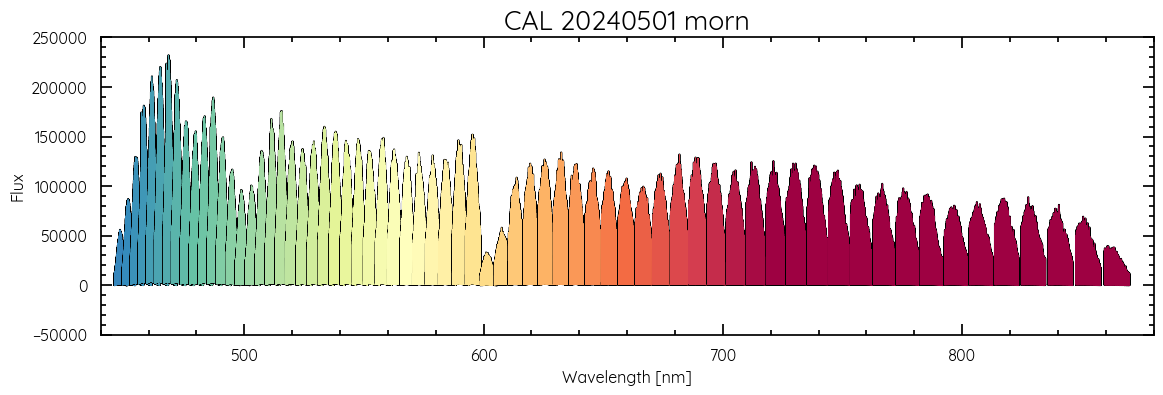

In [11]:
s.plot_spectrum(orderlet="CAL", plot_peaks=False)

Plotting CAL Etalon FSR... DONE


Spectrum /data/kpf/masters/20240501/kpf_20240501_master_WLS_autocal-etalon-all-morn_L1.fits with 1 orderlets:
 - CAL:67 Orders and 13183 total Peaks

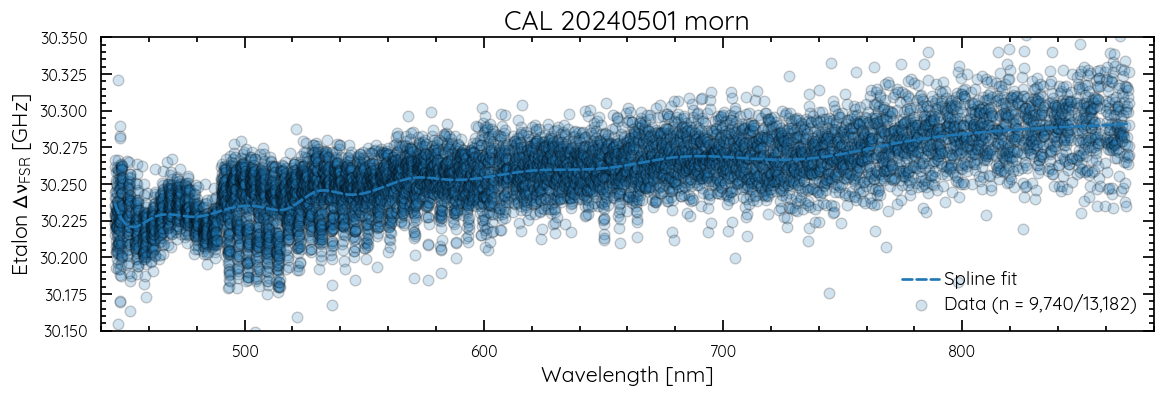

In [12]:
s.plot_FSR(orderlet="CAL")

Plotting fits of CAL etalon peaks... DONE


Spectrum /data/kpf/masters/20240501/kpf_20240501_master_WLS_autocal-etalon-all-morn_L1.fits with 1 orderlets:
 - CAL:67 Orders and 13183 total Peaks

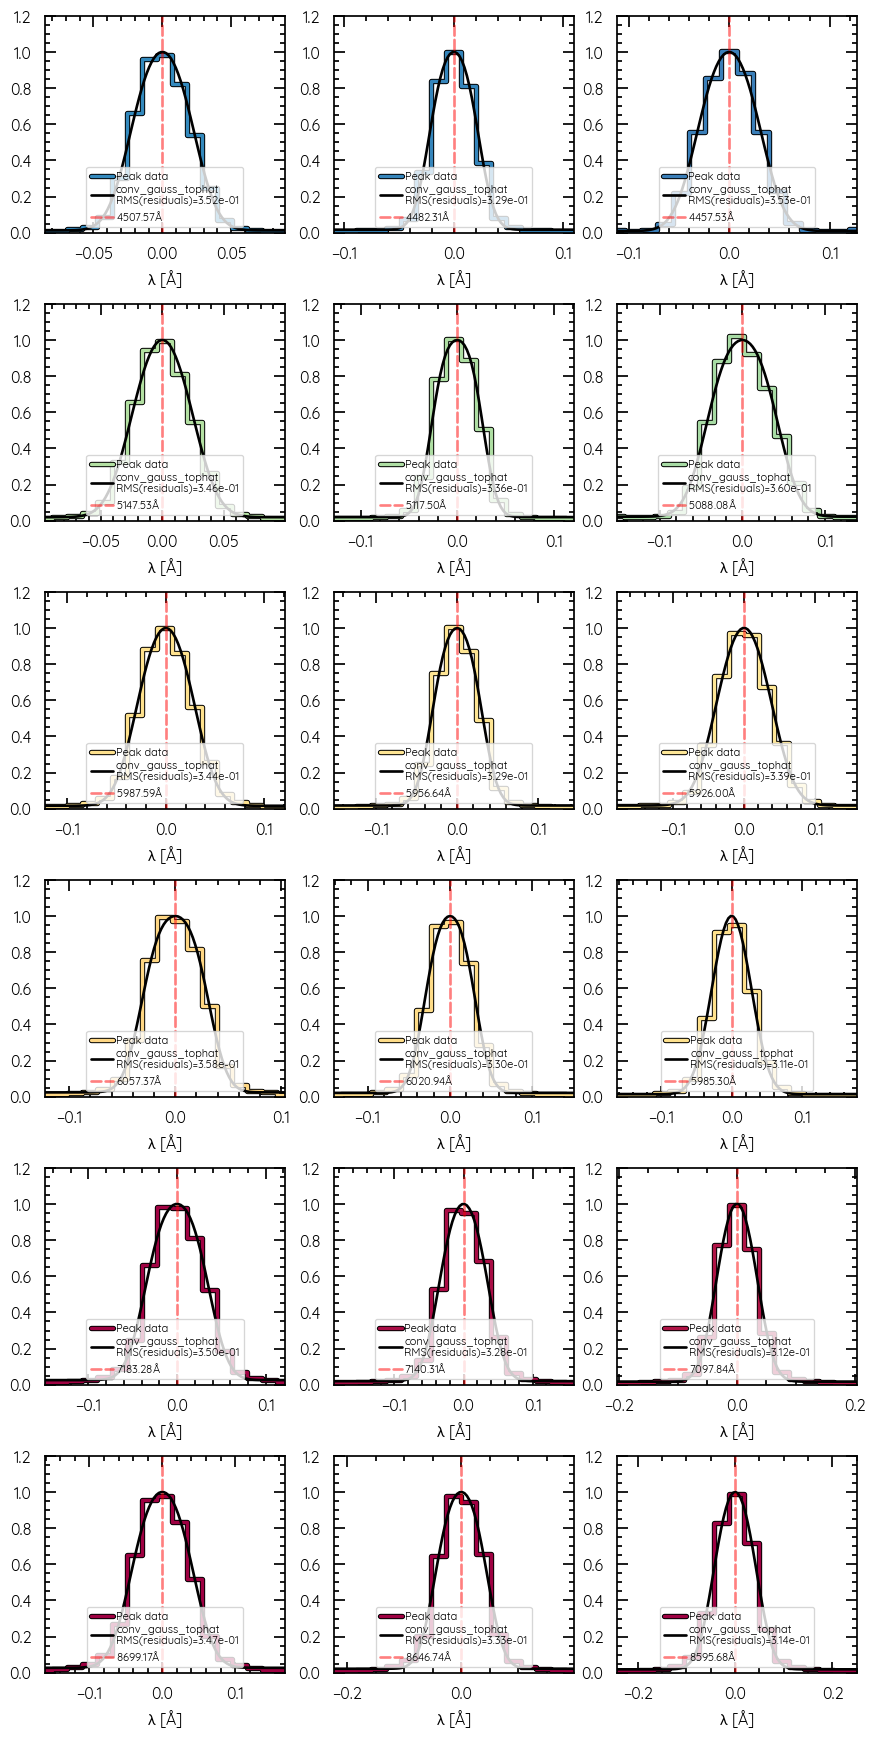

In [13]:
s.plot_peak_fits(orderlet="CAL")